# San Francisco Renting Prices Regression Project

## Importing packages and data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("sf_clean.csv") 
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [30]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


In [16]:
rentals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,989.0,3595.035389,1546.222670,750.0,2650.0,3300.0,4242.0,19000.0
sqft,989.0,976.765420,474.629798,150.0,650.0,900.0,1200.0,3500.0
beds,989.0,1.679474,1.076710,0.0,1.0,2.0,2.0,6.0
bath,989.0,1.390293,0.562714,1.0,1.0,1.0,2.0,4.0


## Data Cleaning

In [17]:
# Although hood_district seems to be a numeric columns, it is in fact a categorical one.
rentals_df['hood_district'] = rentals_df['hood_district'].astype('int').astype('object')
rentals_df['beds'] = rentals_df['beds'].astype('int')
rentals_df['bath'] = rentals_df['bath'].astype('int')

## EDA

### Target

In [20]:
print("Descriptive statistics for the target variable:")
print(rentals_df['price'].describe())

Descriptive statistics for the target variable:
count      989.000000
mean      3595.035389
std       1546.222670
min        750.000000
25%       2650.000000
50%       3300.000000
75%       4242.000000
max      19000.000000
Name: price, dtype: float64


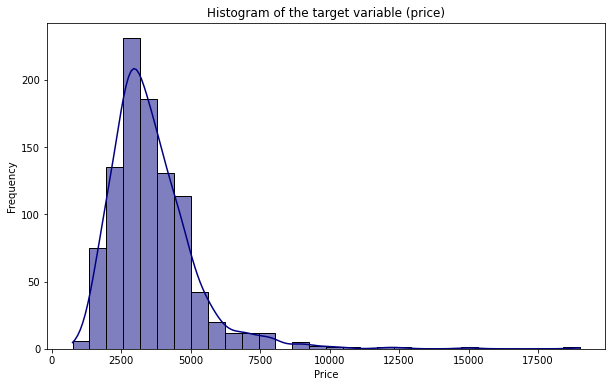

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(rentals_df['price'], bins=30, kde=True, color='navy')
plt.title("Histogram of the target variable (price)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

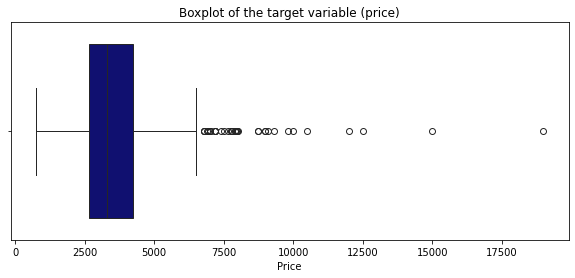

In [26]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=rentals_df['price'], color='navy')
plt.title("Boxplot of the target variable (price)")
plt.xlabel("Price")
plt.show()

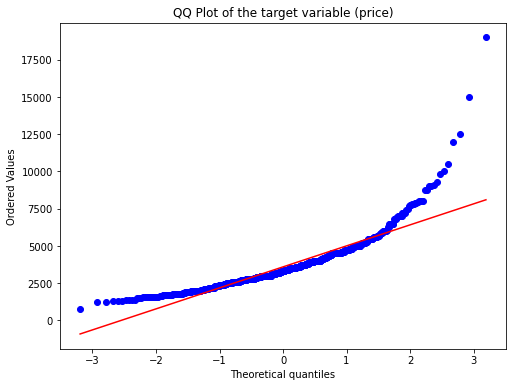

In [30]:
plt.figure(figsize=(8, 6))
stats.probplot(rentals_df['price'], dist="norm", plot=plt)
plt.title("QQ Plot of the target variable (price)")
plt.show()

In [31]:
shapiro_stat, p_value = stats.shapiro(rentals_df['price'])

print("Shapiro-Wilk test statistic:", shapiro_stat)
print("Shapiro-Wilk p-value:", p_value)

Shapiro-Wilk test statistic: 0.831337407916176
Shapiro-Wilk p-value: 4.811954701053989e-31


The Shapiro-Wilk test returned a p-value of 0.000 (p < 0.05), leading to rejection of the null hypothesis of normality. This indicates that the 'price' variable is not normally distributed, and a transformation (e.g., logarithmic) might be considered.

## Feature Engineering


## Data Splitting

## Model Fitting & Validation Scoring

## Assumptions Checking

## Final Model Fit & Test Scoring